In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=30, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.0818
demacare - balance 0.0397
stuff - balance 0.2356
swo - balance 0.2342
ontodt - balance 0.0615
pizza - balance 0.3743


In [5]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240630T144632/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data, None, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.4289 | val loss 1.4289 | acc 0.6370 | f1 0.3567 | prec 0.2560 | recall 0.5878 | roc auc 0.6694 | pr auc 0.3914 | elapsed 2801.21s
train epoch 01/10 | batch 6001/6000 | loss 0.6122 | val loss 0.2951 | acc 0.8934 | f1 0.6850 | prec 0.6931 | recall 0.6771 | roc auc 0.9120 | pr auc 0.7600 | elapsed 3421.43s
train epoch 02/10 | batch 6001/6000 | loss 0.2517 | val loss 0.2004 | acc 0.9259 | f1 0.7751 | prec 0.8065 | recall 0.7460 | roc auc 0.9523 | pr auc 0.8574 | elapsed 3416.01s
train epoch 03/10 | batch 6001/6000 | loss 0.1938 | val loss 0.1662 | acc 0.9386 | f1 0.8132 | prec 0.8481 | recall 0.7811 | roc auc 0.9660 | pr auc 0.8929 | elapsed 3437.47s
train epoch 04/10 | batch 6001/6000 | loss 0.1669 | val loss 0.1469 | acc 0.9463 | f1 0.8370 | prec 0.8705 | recall 0.8060 | roc auc 0.9732 | pr auc 0.9126 | elapsed 3417.11s
train epoch 05/10 | batch 6001/6000 | loss 0.1504 | val loss 0.1344 | acc 0.9506 | f1 0.

In [6]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log_orig = train(data, None, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.2405 | val loss 1.2405 | acc 0.6687 | f1 0.4098 | prec 0.2948 | recall 0.6717 | roc auc 0.7291 | pr auc 0.4236 | elapsed 687.86s
train epoch 01/10 | batch 6001/6000 | loss 0.4911 | val loss 0.2616 | acc 0.9095 | f1 0.7313 | prec 0.7437 | recall 0.7193 | roc auc 0.9239 | pr auc 0.8041 | elapsed 1118.48s
train epoch 02/10 | batch 6001/6000 | loss 0.2379 | val loss 0.2017 | acc 0.9304 | f1 0.7880 | prec 0.8240 | recall 0.7550 | roc auc 0.9502 | pr auc 0.8621 | elapsed 1127.09s
train epoch 03/10 | batch 6001/6000 | loss 0.1993 | val loss 0.1777 | acc 0.9389 | f1 0.8134 | prec 0.8523 | recall 0.7779 | roc auc 0.9608 | pr auc 0.8860 | elapsed 1120.60s
train epoch 04/10 | batch 6001/6000 | loss 0.1802 | val loss 0.1633 | acc 0.9441 | f1 0.8298 | prec 0.8674 | recall 0.7953 | roc auc 0.9668 | pr auc 0.9004 | elapsed 1117.79s
train epoch 05/10 | batch 6001/6000 | loss 0.1676 | val loss 0.1538 | acc 0.9469 | f1 0.8387 |

local/out/exp/20240706T225351
------
Frozen pre-trained reasoner head original
train time 9369.116577625275
           mean     std   micro
acc      0.9564  0.0338  0.9564
prec     0.9125  0.0618  0.8978
recall   0.8246  0.0982  0.8410
f1       0.8648  0.0761  0.8685
auc_roc  0.9745  0.0171  0.9792
auc_pr   0.9256  0.0553  0.9339
------
Frozen pre-trained reasoner head
train time 25600.6869699955
           mean     std   micro
acc      0.9630  0.0302  0.9630
prec     0.9231  0.0623  0.9119
recall   0.8472  0.1019  0.8679
f1       0.8822  0.0796  0.8893
auc_roc  0.9818  0.0152  0.9865
auc_pr   0.9413  0.0551  0.9522


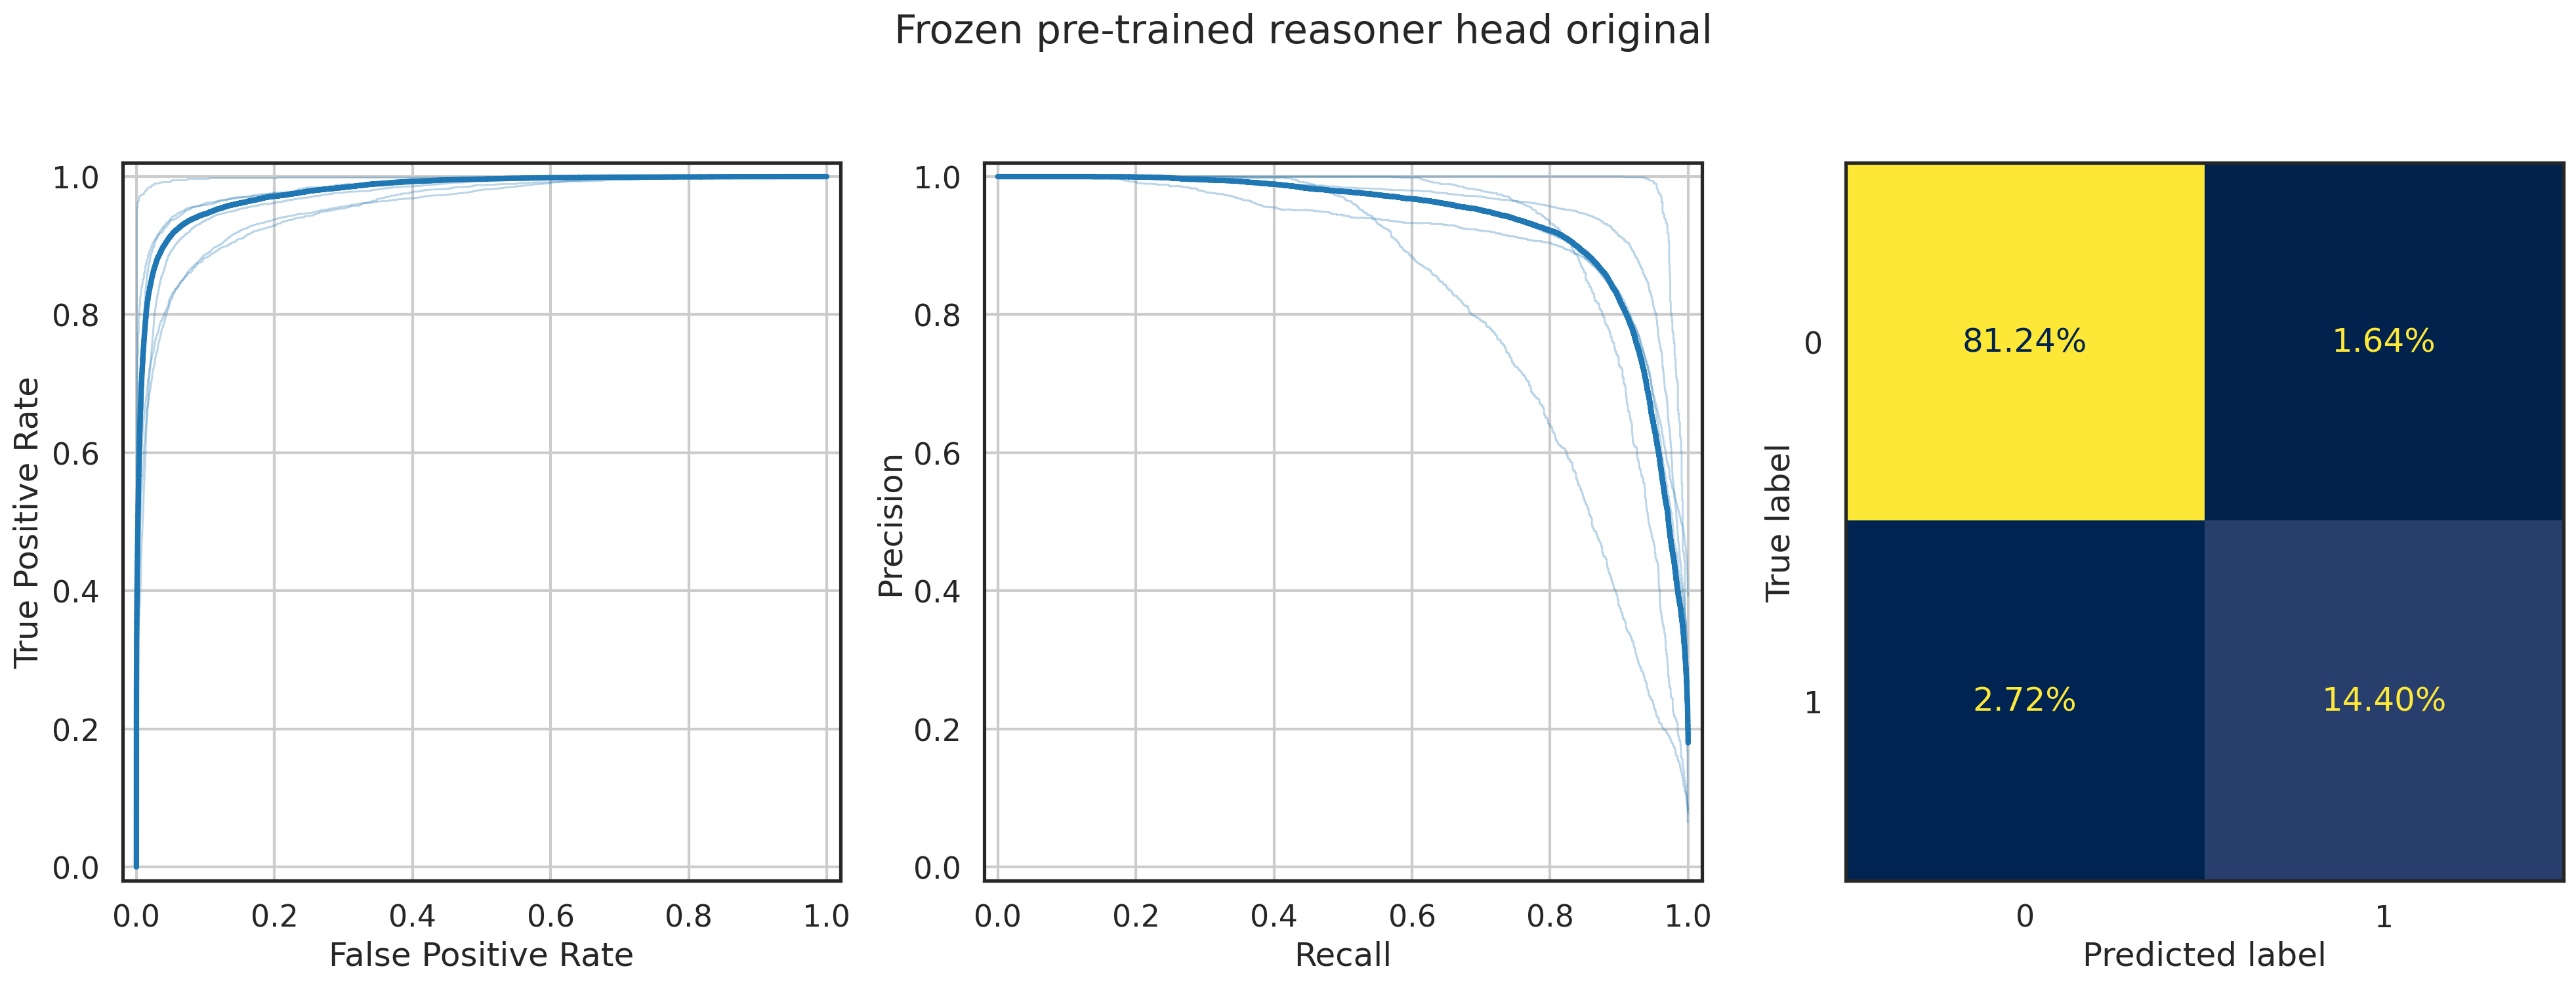

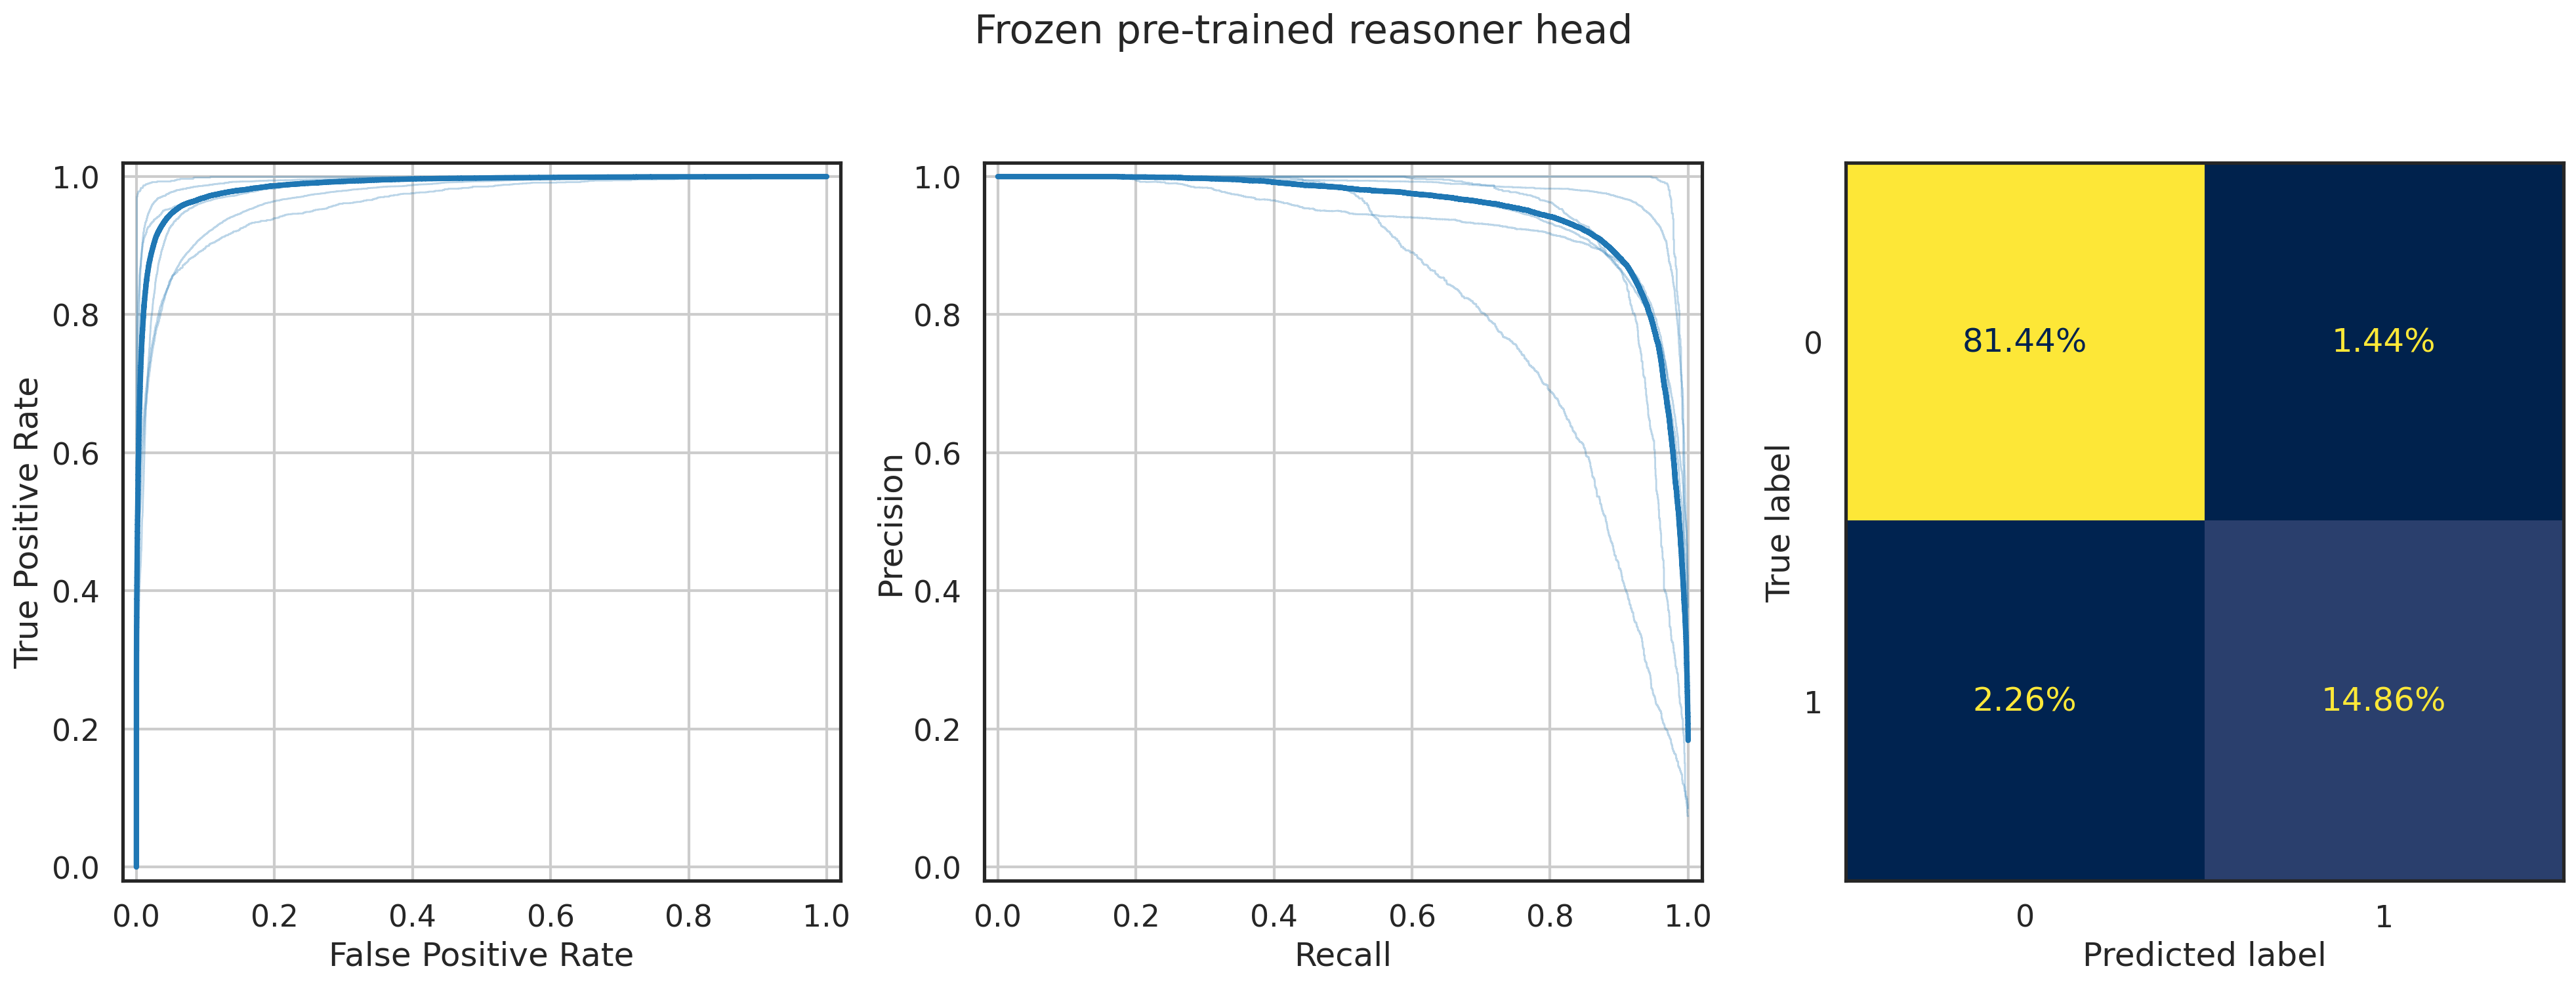

In [7]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [8]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Frozen pre-trained reasoner head original
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9611  0.7374  0.8231  0.6678   0.9568  0.8248  wildlife
61  0.9975  0.9676  0.9975  0.9394   0.9986  0.9882  demacare
62  0.9372  0.8632  0.8877  0.8399   0.9697  0.9197     stuff
63  0.9571  0.9072  0.9197  0.8950   0.9817  0.9575       swo
64  0.9832  0.8467  0.9619  0.7561   0.9852  0.9240    ontodt
65  0.9023  0.8668  0.8850  0.8494   0.9550  0.9393     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9618  0.7419  0.8285  0.6716   0.9605  0.8376  wildlife
61  0.9978  0.9717  1.0000  0.9449   0.9994  0.9925  demacare
62  0.9450  0.8814  0.8956  0.8678   0.9797  0.9371     stuff
63  0.9742  0.9443  0.9565  0.9324   0.9936  0.9820       swo
64  0.9854  0.8699  0.9653  0.7917   0.9895  0.9450    ontodt
65  0.9139  0.8839  0.8930  0.8749   0.9683  0.9534     pizza
